# Entropic force from a polymer chain
Let's simulate a polymer chain under a force as a [freely-jointed chain](https://en.wikipedia.org/wiki/Ideal_chain#Ideal_chain_under_a_constant_force_constraint_%E2%80%93_calculation).

Some initial messing around:

In [1]:
import numpy as np
link_displacements = np.random.randn(3,100)
link_displacements /= np.linalg.norm(link_displacements, axis=0)
atom_locations = np.cumsum(link_displacements,axis=1)

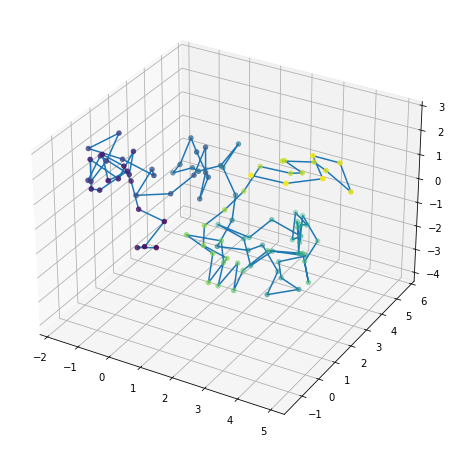

In [2]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
ax.plot(xs = atom_locations[0], ys = atom_locations[1], zs = atom_locations[2], )
ax.scatter(xs = atom_locations[0], ys = atom_locations[1], zs = atom_locations[2], 
           c = np.arange(100))

# Physical realism
From Discord convo with Birch:  
T = 300K, persistence length = 41.2e-9 m, contour length = 1316 nm   
(the persistence length and contour length were just from a specific paper
i was looking at. ive been messing around with them)

In other words, 1316e-9m total length, 41.2e-9 segment length

Unused links for reference:  
https://dpotoyan.github.io/Statmech4ChemBio/labs/lab2/polymer-conf.html  
https://courses.physics.illinois.edu/phys213/fa2013/lectures/lecture11.pdf  
https://softmath.seas.harvard.edu/wp-content/uploads/2019/10/2018-01.pdf  

In [3]:
1316e-9 / (41.2e-9) # segment count is about 32
segments = 32
force = 0.2e-12 # Newtons, but should range from 0 to 2 picoNewtons
segment_length = 41.2e-9

k_B = 1.380649e-23 # Boltzmann's constant, in J\cdot K^{-1}
temperature = 300 # Kelvin

(force*segment_length)/(k_B*temperature), 
np.exp((force*segment_length)/(k_B*temperature))

7.311164536596991

Boltzmann distribution probability ratio:

${\displaystyle {\frac {p_{i}}{p_{j}}}=\exp \left({\frac {\varepsilon _{j}-\varepsilon _{i}}{kT}}\right)}$

energy is just force x distance.

$$\frac{ p_{\text{new}} }{ p_{\text{old}} } = \exp\left( \frac{ E_{\text{old}} - E_{\text{new}} }{k_B T} \right)
= \exp\left( \frac{ F(-x_{\text{old}}) - F(-x_{\text{new}}) }{k_B T} \right) 
= \exp\left( \frac{ F(x_{\text{new}} - x_{\text{old}}) }{k_B T} \right)$$


In [4]:
# Make a random set of polymer chain-link orientations
# (think of it as a sequence of vectors from beginning to end).
# For thermodynamic purposes, we typically only care about the length 
# (so, maybe, just the x-coordinate of the end?), 
# but we're working in 3D, which may be inefficient, but it provides
# a convenient way to sample random orientations on a sphere.
link_displacements = np.random.randn(3,segments)
link_displacements /= np.linalg.norm(link_displacements, axis=0)
link_displacements *= segment_length
atom_locations = np.cumsum(link_displacements,axis=1)
#link_displacements[2] # z-coordinates

In [5]:
iterations = 100
link_displacements_record = np.zeros((iterations,3,segments))

for ii in range(iterations):
    # Draw a random new orientation for each segment
    link_displacements_new = np.random.randn(3,segments)
    link_displacements_new /= np.linalg.norm(link_displacements_new, axis=0)
    link_displacements_new *= segment_length

    # perturb the polymer chain via Boltzmann distribution 
    # which is basically the Metropolis-Hastings algorithm
    # make the Boltmann energy just the negative of the x-coordinate of
    # the far end of the chain (rightward force)
    acceptance_ratios = np.exp(force*(link_displacements_new[0]-link_displacements[0])/
                               (k_B*temperature)
                              )
    acceptance = (np.random.random(size=(segments)) < acceptance_ratios) # Booleans
    #acceptance
    link_displacements[:,acceptance] = link_displacements_new[:,acceptance]
    
    link_displacements_record[ii] = link_displacements
atom_locations_record = np.cumsum(link_displacements_record,axis=2)

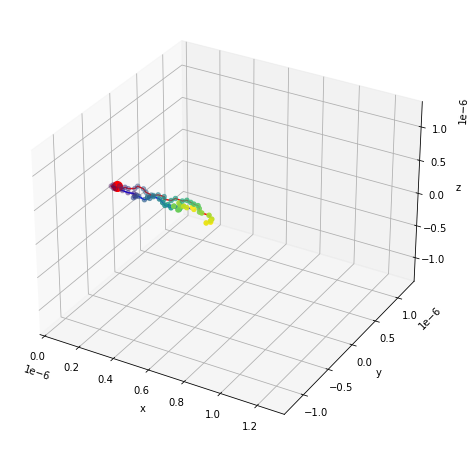

In [6]:
# Plot once
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(xs = [0], ys = [0], zs = [0], c = 'red', s=100)

atom_locations = atom_locations_record[-1]
ax.plot(xs = atom_locations[0], ys = atom_locations[1], zs = atom_locations[2],
        color='red')
ax.scatter(xs = atom_locations[0], ys = atom_locations[1], zs = atom_locations[2],
           c = np.arange(segments))

length_scale = segments*segment_length
ax.set(xlim=[0, length_scale], 
       ylim=[-length_scale, length_scale], 
       zlim=[-length_scale, length_scale]
       ,xlabel='x', ylabel='y', zlabel='z')

atom_locations = atom_locations_record[0]
ax.plot(xs = atom_locations[0], ys = atom_locations[1], zs = atom_locations[2],
        color='blue')
ax.scatter(xs = atom_locations[0], ys = atom_locations[1], zs = atom_locations[2],
           c = np.arange(segments))

In [7]:
# Plot many times (aka animate)
import matplotlib.animation as animation
# Using this backend causes a popup window to appear with the animated plot...
# ... which means that it doesn't show up in this static report.
%matplotlib tk 

# Initialize the figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs = [0], ys = [0], zs = [0], c = 'red', s=25)

# Initial line and scatter plot
atom_locations = atom_locations_record[0]
line, = ax.plot(xs = atom_locations[0], ys = atom_locations[1], zs = atom_locations[2], 
                color='red')
dots = ax.scatter(xs = atom_locations[0], ys = atom_locations[1], 
                  zs = atom_locations[2], 
                  c = np.arange(segments))
# Doing both a scatter (for dots) and a plot (for lines) is a little silly, 
# but it's a way to get some color-gradienting, since I want connecting lines
# (all segments must be the same color) and also a color gradient 
# (which I can get by making dots, aka scatter, each colored differently).

# Set axis limits
length_scale = segments * segment_length
ax.set(xlim=[0, length_scale], 
       ylim=[-length_scale, length_scale], 
       zlim=[-length_scale, length_scale],
       xlabel='x', ylabel='y', zlabel='z')


def update(frame):
    # for each frame, update the data stored on each artist.
    # update the line plot:
    line.set_data_3d(atom_locations_record[frame])
    
    # Update the scatter plot
    dots._offsets3d = (atom_locations_record[frame][0], 
                       atom_locations_record[frame][1], 
                       atom_locations_record[frame][2])

    return (line, dots)


# Create animation
ani = animation.FuncAnimation(fig=fig, func=update, frames=iterations, interval=30)
#ani.save("jiggly_string.mp4")
plt.show()


In [8]:
# Let's parameterize and turn it into a function

def simulate_polymer(segments = 32, force = 0.2e-12, segment_length = 41.2e-9, 
                     temperature = 300, iterations = 100):
    '''
    Use the Metropolis-Hastings algorithm to sample the atom arrangements of a 
    jiggly polymer, modeled as a chain of fixed-length line segments with 
    infinitely flexible joints between. 
    The force is in Newtons (e-12 makes it picoNewtons), 
    segment length in meters (e-9 makes it nanometers),
    and temperature is in Kelvin.
    '''
    k_B = 1.380649e-23 # Boltzmann's constant, in J\cdot K^{-1}

    # Make a random set of polymer chain-link orientations
    # (think of it as a sequence of vectors from beginning to end).
    # For thermodynamic purposes, we typically only care about the length 
    # (so, maybe, just the x-coordinate of the end?), 
    # but we're working in 3D, which may be inefficient, but it provides
    # a convenient way to sample random orientations on a sphere.
    link_displacements = np.random.randn(3,segments)
    link_displacements /= np.linalg.norm(link_displacements, axis=0)
    link_displacements *= segment_length

    link_displacements_record = np.zeros((iterations,3,segments))

    for ii in range(iterations):
        # Roll a random new orientation for each segment
        link_displacements_new = np.random.randn(3,segments)
        link_displacements_new /= np.linalg.norm(link_displacements_new, axis=0)
        link_displacements_new *= segment_length

        # We're working with a Boltzmann distribution, for which 
        # the Boltmann energy just the negative of the x-coordinate of
        # the far end of the chain (force in the positive x-direction).
        acceptance_ratios = np.exp(force*(link_displacements_new[0]
                                          -link_displacements[0])
                                   /(k_B*temperature))
        # With the acceptance probabilities (aka state probability ratios new/old) 
        # chosen, we can parallelize and work on the orientation of each polymer 
        # link separately; the fact that each polymer link orientation independently 
        # (linearly) affects the total energy (for Boltzmann purposes) is why 
        # we can vectorize these calculations.
        acceptance = (np.random.random(size=(segments)) < acceptance_ratios) # Booleans
        # Based on random chance, update the link displacements:
        link_displacements[:,acceptance] = link_displacements_new[:,acceptance]

        # Write it down
        link_displacements_record[ii] = link_displacements
    
    return np.cumsum(link_displacements_record,axis=2)

atom_locations_record = simulate_polymer()
# Sanity check:
# for the last frame of simulation, get the x-coordinate of the last atom
atom_locations_record[-1][0][-1] 

6.616598986694895e-07

Theoretical:

$ {\displaystyle \langle R\rangle =-{\frac {\partial G}{\partial f}}=Nl\left[\coth \left({\frac {fl}{k_{\text{B}}T}}\right)-{\frac {k_{\text{B}}T}{fl}}\right]} $

(from Wikipedia: https://en.wikipedia.org/wiki/Ideal_chain#Ideal_chain_under_a_constant_force_constraint_%E2%80%93_calculation )

(This model is also given in Table 1, page 1342, of "Stretching DNA with Optical Tweezers", *Biophysical Journal* Volume 72, March 1997, p 1335-1346)

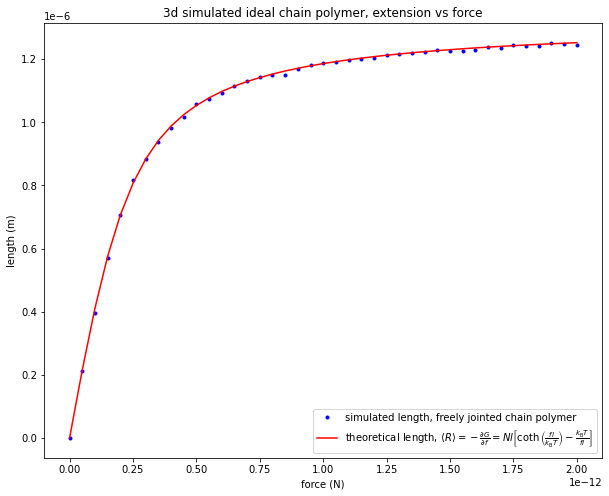

In [14]:
# Make plotplotlib embed the graphs
%matplotlib inline 

forces = np.linspace(0.00001e-12, 2e-12, 41)

model_lengths = [segments *segment_length * 
     (np.cosh(force * segment_length/k_B/temperature)
      /np.sinh(force * segment_length/k_B/temperature) 
      -k_B * temperature/force/segment_length)
     for force in forces]

# after a burn-in period of 10 iterations, 
# average (over the remaining iterations) the x-coordinate of the terminal atom
average_lengths = [np.mean(simulate_polymer(force=force, iterations=1000)[10:,0,-1], 
                           axis=0) 
                   for force in forces]

fig,ax = plt.subplots(figsize=(10,8))

ax.plot(forces, average_lengths, 'b.', 
        label='simulated length, freely jointed chain polymer')
ax.plot(forces, model_lengths, 'r-', 
        label=
        r"theoretical length, $ \langle R\rangle"
        r"=-{\frac {\partial G}{\partial f}} "
        r"= Nl\left[\coth \left({\frac {fl}{k_{\mathrm{B}}T}}\right)"
        r"-{\frac {k_{\mathrm{B}}T}{fl}}\right]$"
       )
ax.legend()
ax.set_xlabel('force (N)')
ax.set_ylabel('length (m)')
ax.set_title('3d simulated ideal chain polymer, extension vs force')
plt.savefig('3d polymer length vs force.png')
plt.show()